# Importing Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from sklearn import linear_model, feature_selection, metrics, model_selection, datasets
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
import pypalettes
import warnings
warnings.filterwarnings('ignore')

counties_pol_party = pd.read_csv('counties_pol.csv')

In [3]:
counties_pol_party.shape
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

In [4]:
# changing fips to str value
counties_pol_party['fips']= counties_pol_party['fips'].astype(str)

## Standardizing Values

In [5]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
counties_pol_copy = counties_pol_party.copy()

In [6]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [7]:
z_counties= calc_z(counties_pol_copy, vars_to_z)

# Variable Selection with Pairwise Mutual Information 

In [8]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_party[[var1]]
        y = counties_pol_party[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.111732               0.076835   
gender_pay_gap                        0.048046               0.005633   
school_segration_index                0.019953               0.038607   
residential_segregation               0.046270               0.001665   
school_funding_gap                    0.225698               0.034388   

                         population  median_income  uninsured__percentage  \
income_inequality          0.026233       0.209543               0.072561   
gender_pay_gap             0.067351       0.020464               0.028855   
school_segration_index     0.190105       0.027709               0.005945   
residential_segregation    0.080537       0.021808               0.072622   
school_funding_gap         0.088524       0.249631               0.247338   

                         premature_death  child_poverty_percentage  \
income_inequality           

## Visualizing Pairwise Mutual Information as Heatmap

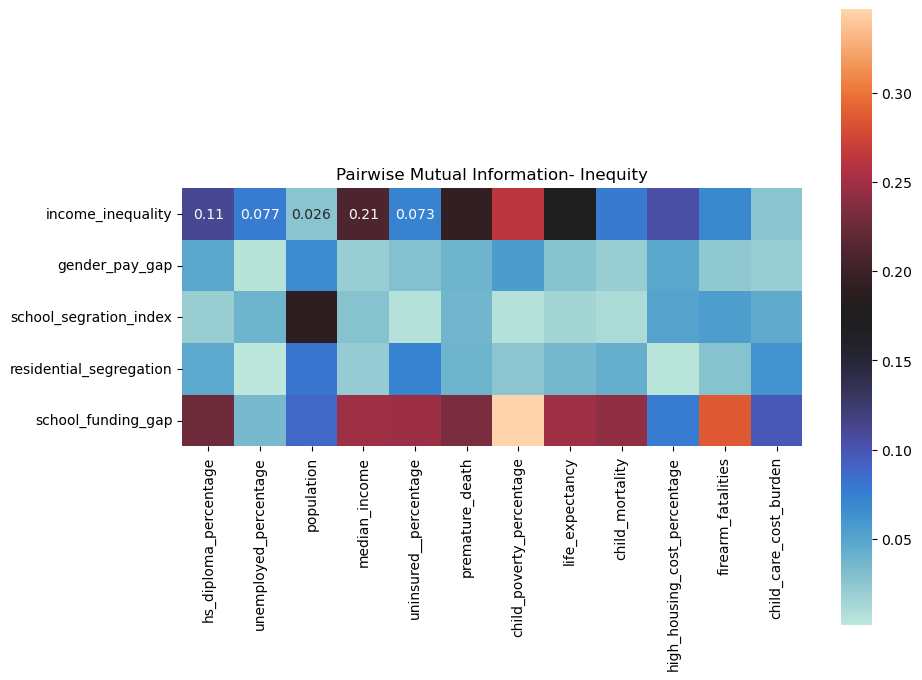

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='icefire', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

# Identifying most 'informative' pairs

In [10]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap        0.346790
firearm_fatalities        school_funding_gap        0.286277
child_poverty_percentage  income_inequality         0.262447
median_income             school_funding_gap        0.249631
life_expectancy           school_funding_gap        0.248474
uninsured__percentage     school_funding_gap        0.247338
child_mortality           school_funding_gap        0.242621
premature_death           school_funding_gap        0.232733
hs_diploma_percentage     school_funding_gap        0.225698
median_income             income_inequality         0.209543
premature_death           income_inequality         0.191951
population                school_segration_index    0.190105
dtype: float64


### Selecting most 'informative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

*including political party elected from 2020 general election for additional comparative visualizations*

In [11]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_party[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality']
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

# Descriptive Statistics for Selected Variables

In [12]:
agg_select_subset.describe().round(2)

school_funding_gap  child_poverty_percentage  income_inequality  \
count             1648.00                   1648.00            1648.00   
mean              -804.97                      0.19               4.60   
std               6428.72                      0.08               0.71   
min             -46776.99                      0.03               2.88   
25%              -3452.36                      0.13               4.10   
50%               -309.82                      0.18               4.49   
75%               2283.42                      0.23               4.98   
max              21187.84                      0.54               8.28   

       firearm_fatalities  median_income  life_expectancy  premature_death  
count             1648.00        1648.00          1648.00          1648.00  
mean                16.77       67337.94            74.85         10482.46  
std                  7.60       16490.49             3.22          3315.20  
min                  1.86       34176.00            63.84          3990.29  
25%                 11.69       55568.00            72.60          8089.24  
50%                 15.87       64090.50            74.88         10155.80  
75%                 20.47       75447.00            77.07         12482.99  
max                 79.46      144807.00            89.67         27851.41

In [13]:
print(sns.color_palette('icefire', 8).as_hex())

['#6bb2cd', '#377ad0', '#444282', '#242430', '#332023', '#782c3f', '#c93f3a', '#ef8748']


In [14]:
icefire_colors = ['#6bb2cd', '#377ad0', '#444282', '#242430', '#332023', '#782c3f', '#c93f3a', '#ef8748']

In [15]:
def plot_histograms_boxplots(data, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(12, 4 * len(columns)))
    for i, col in enumerate(columns):
        # Histogram
        sns.histplot(data[col], kde=True, ax=axes[i, 0], color='#4954b0')
        axes[i, 0].set_title(f'Histogram of {col}')
        # Boxplot
        sns.boxplot(x=data[col], ax=axes[i, 1], color='#9c2f45')
        axes[i, 1].set_title(f'Boxplot of {col}')
    plt.tight_layout()

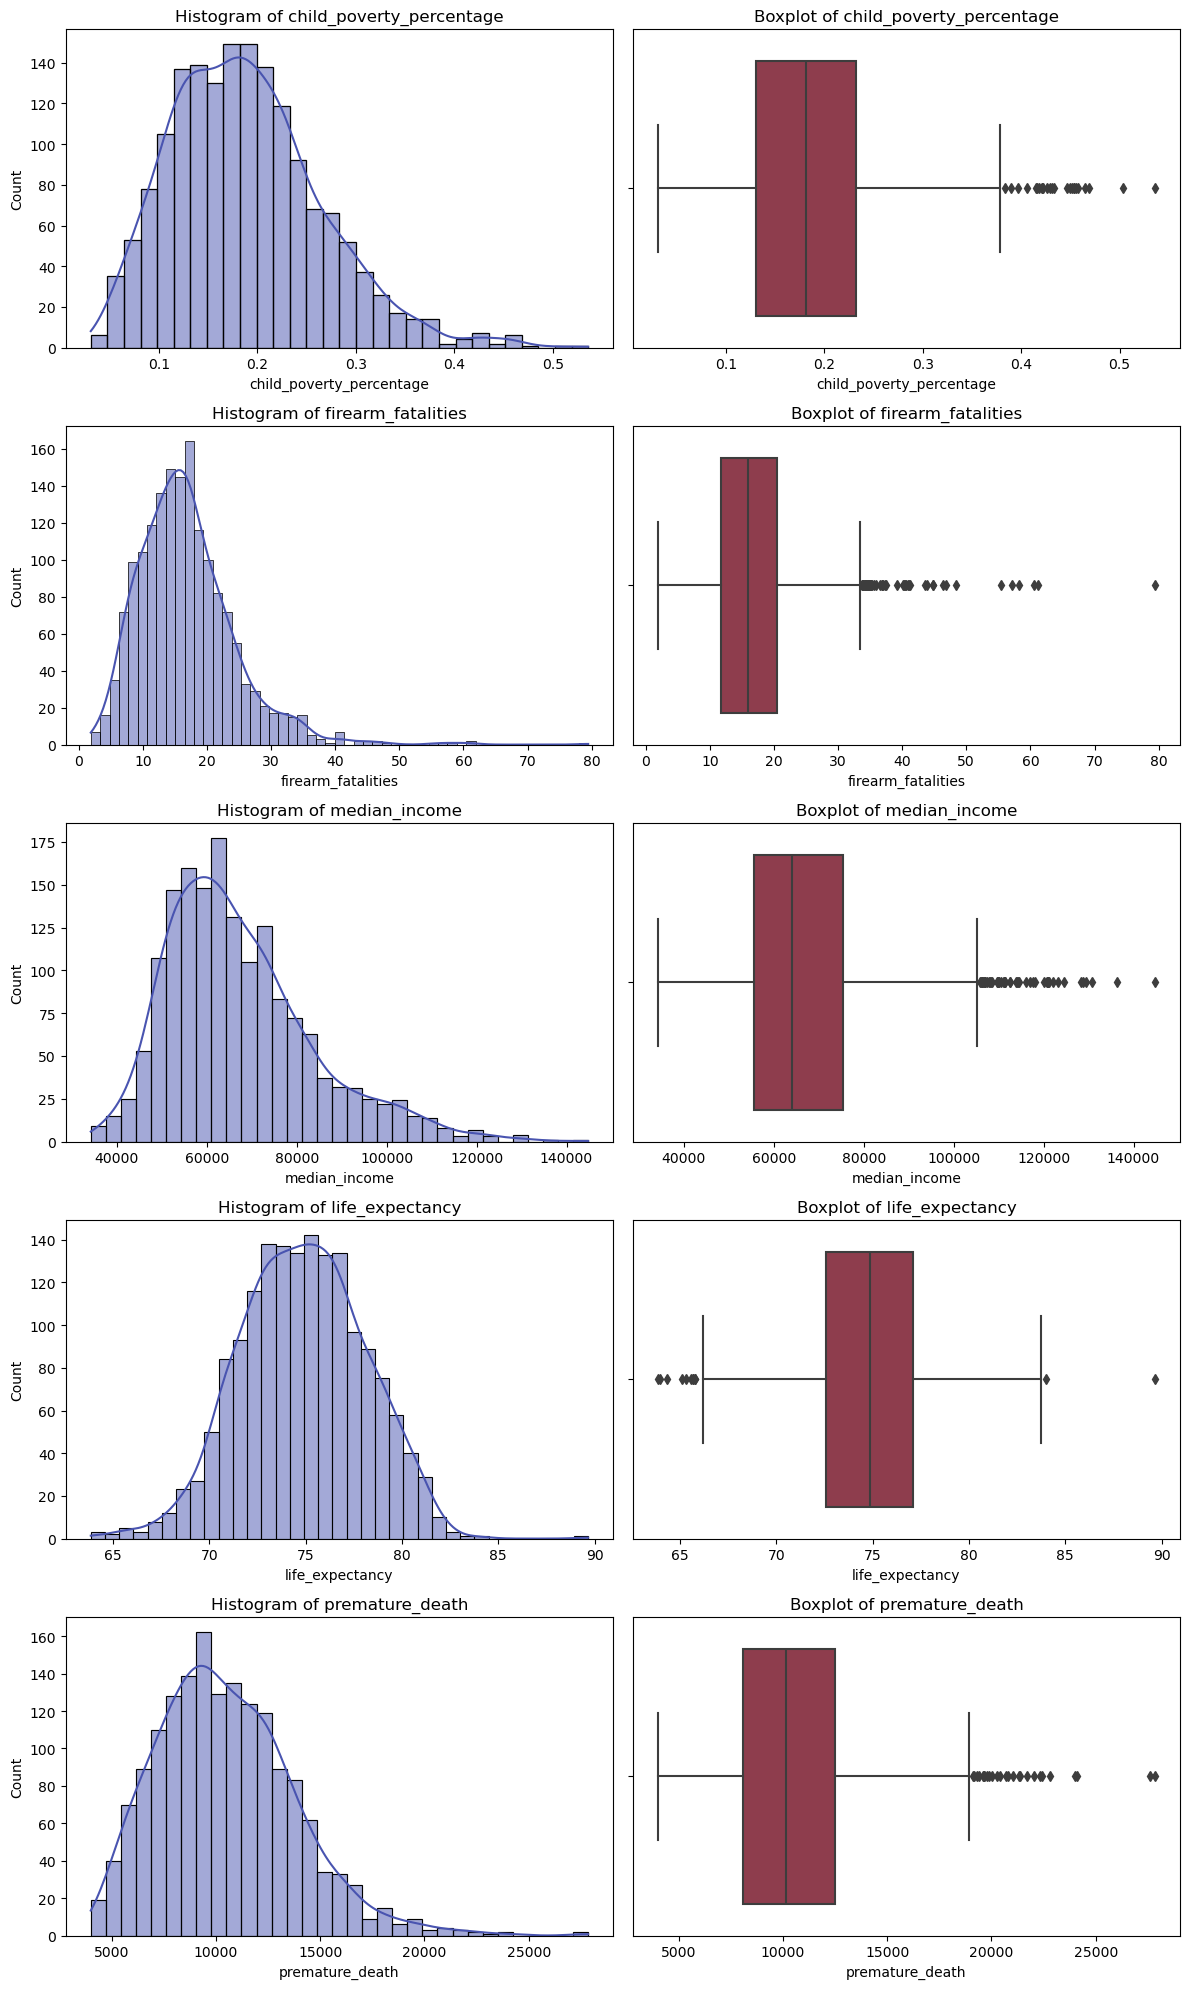

In [16]:
plot_histograms_boxplots(agg_select_subset, y_vars)

## Variance 

In [17]:
agg_select_subset.var(numeric_only=True)

school_funding_gap          4.132847e+07
child_poverty_percentage    5.870140e-03
income_inequality           5.075141e-01
firearm_fatalities          5.772999e+01
median_income               2.719364e+08
life_expectancy             1.040037e+01
premature_death             1.099053e+07
dtype: float64

## Correlation 

<Axes: >

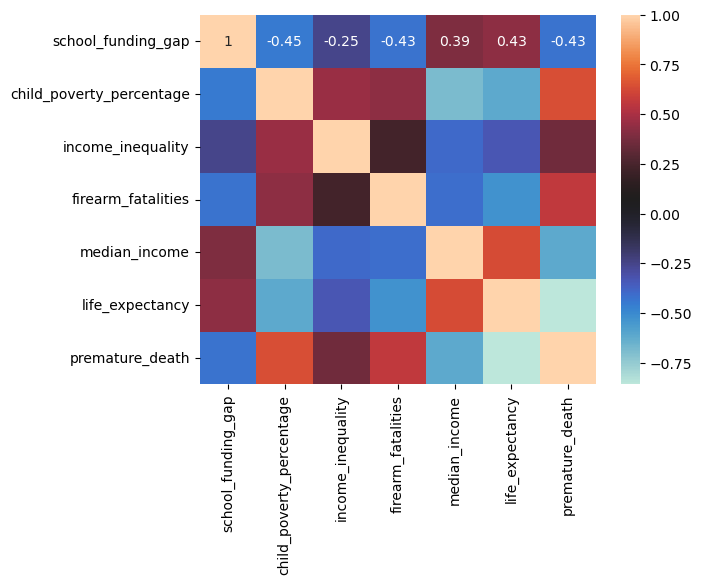

In [18]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='icefire')

### Correlation Pairs

In [19]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

child_poverty_percentage   -0.637112
firearm_fatalities         -0.604100
median_income               0.496392
life_expectancy             0.564720
premature_death            -0.579993
dtype: float64


In [20]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

child_poverty_percentage    0.622599
firearm_fatalities          0.366110
median_income              -0.503023
life_expectancy            -0.458570
premature_death             0.512731
dtype: float64


### Covariance

In [21]:
agg_select_subset.cov(numeric_only=True).round(2)

school_funding_gap  child_poverty_percentage  \
school_funding_gap               41328467.77                   -313.81   
child_poverty_percentage             -313.81                      0.01   
income_inequality                   -1604.99                      0.03   
firearm_fatalities                 -29507.62                      0.36   
median_income                    52623929.12                  -1025.68   
life_expectancy                     11707.99                     -0.19   
premature_death                 -12361094.39                    206.09   

                          income_inequality  firearm_fatalities  \
school_funding_gap                 -1604.99           -29507.62   
child_poverty_percentage               0.03                0.36   
income_inequality                      0.51                1.98   
firearm_fatalities                     1.98               57.73   
median_income                      -5909.43           -67516.43   
life_expectancy                       -1.05              -16.64   
premature_death                     1210.94            18173.46   

                          median_income  life_expectancy  premature_death  
school_funding_gap         5.262393e+07         11707.99     -12361094.39  
child_poverty_percentage  -1.025680e+03            -0.19           206.09  
income_inequality         -5.909430e+03            -1.05          1210.94  
firearm_fatalities        -6.751643e+04           -16.64         18173.46  
median_income              2.719364e+08         41980.70     -41437689.02  
life_expectancy            4.198070e+04            10.40        -10274.20  
premature_death           -4.143769e+07        -10274.20      10990534.91

## Pair Plots

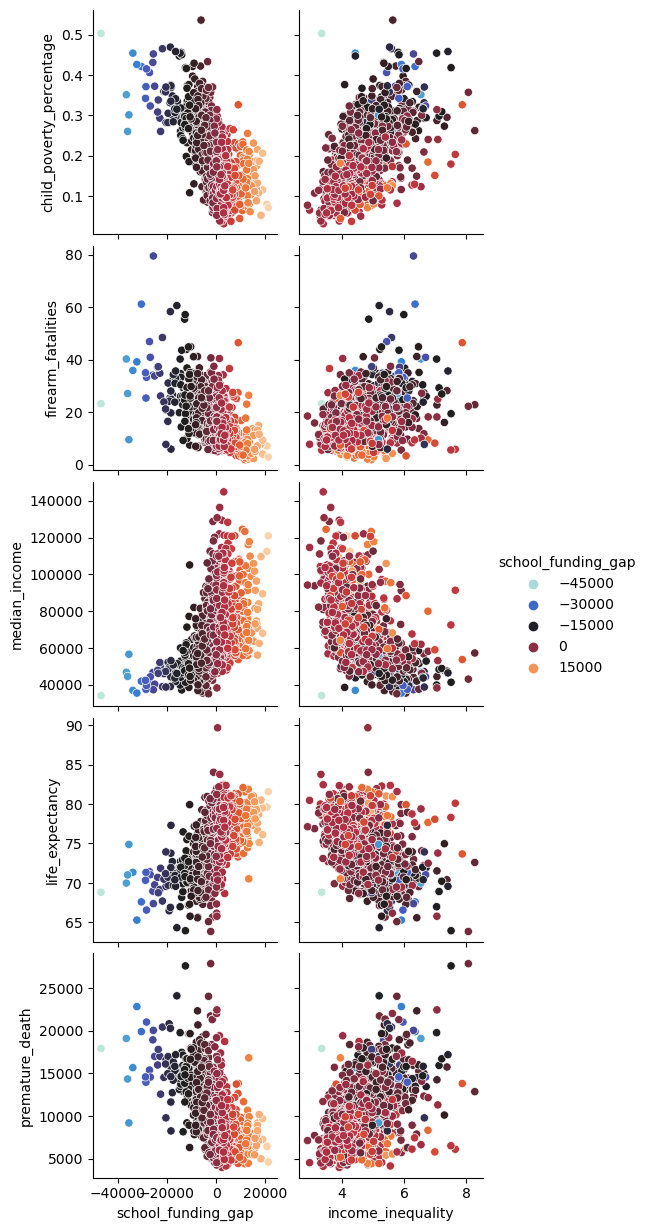

In [22]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    hue = 'school_funding_gap',
    palette='icefire',
    )     

# Regression

focusing on highest correlation pairs:
### school_funding
- child_poverty_percentage
- firearm_fatalities
- life_expectancy 

### income_inequality 
- child_poverty_percentage
- median_income
- premature_death

In [23]:
X_1 = agg_select_subset['school_funding_gap']
X_2 = agg_select_subset['income_inequality']
y_1 = agg_select_subset['child_poverty_percentage']
y_2 = agg_select_subset['firearm_fatalities']
y_3 = agg_select_subset['median_income']
y_4 = agg_select_subset['life_expectancy']
y_5 = agg_select_subset['premature_death']

## Linear Regression


Define function for plotting pairs of interest individually

In [24]:
line_color2 = '#BF1717'
line_color_1='#2D83A6'

In [25]:
def poly_reg_line(x_val, y_val, slope_val, intercept_val):
    sns.scatterplot(x = x_val, y = y_val, hue = x_val, palette ='icefire') 
    slope_val, intercept_val = np.polyfit(x_val, y_val, 1)
    plt.plot(x_val, slope_val*x_val + intercept_val, color= '#BF1717', label='Regression Line')

### Plotting School Funding 

#### Child Poverty

In [26]:
model_1= smf.ols(formula='child_poverty_percentage ~ school_funding_gap', data=agg_select_subset).fit()
intercept_1 = model_1.params.Intercept
slope_1 = model_1.params.school_funding_gap

print(model_1.summary())

                               OLS Regression Results                               
Dep. Variable:     child_poverty_percentage   R-squared:                       0.406
Model:                                  OLS   Adj. R-squared:                  0.406
Method:                       Least Squares   F-statistic:                     1125.
Date:                      Wed, 14 May 2025   Prob (F-statistic):          2.34e-188
Time:                              15:42:36   Log-Likelihood:                 2324.8
No. Observations:                      1648   AIC:                            -4646.
Df Residuals:                          1646   BIC:                            -4635.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

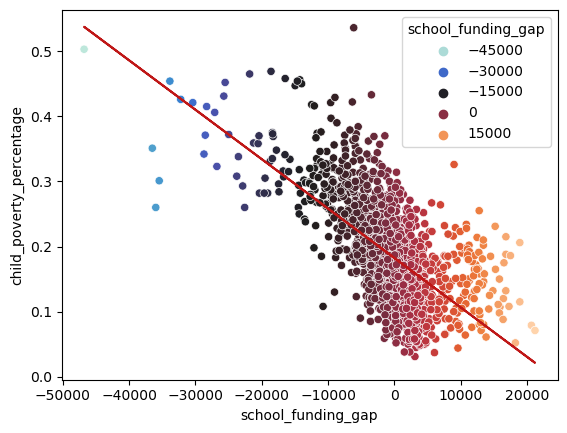

In [27]:
poly_reg_line(X_1, y_1, slope_1, intercept_1)

#### Firearm Fatalities 

In [28]:
model_2= smf.ols(formula='firearm_fatalities ~ school_funding_gap', data=agg_select_subset).fit()
intercept_2 = model_2.params.Intercept
slope_2 = model_2.params.school_funding_gap
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     firearm_fatalities   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     945.9
Date:                Wed, 14 May 2025   Prob (F-statistic):          1.70e-164
Time:                        15:42:51   Log-Likelihood:                -5305.7
No. Observations:                1648   AIC:                         1.062e+04
Df Residuals:                    1646   BIC:                         1.063e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.1915      0.150    107.682      0.000      15.897      16.486
school_funding_gap    -0.0007   2.32e-05    -30.755      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      434.019   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2445.510
Skew:                           1.111   Prob(JB):                         0.00
Kurtosis:                       8.539   Cond. No.                     6.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

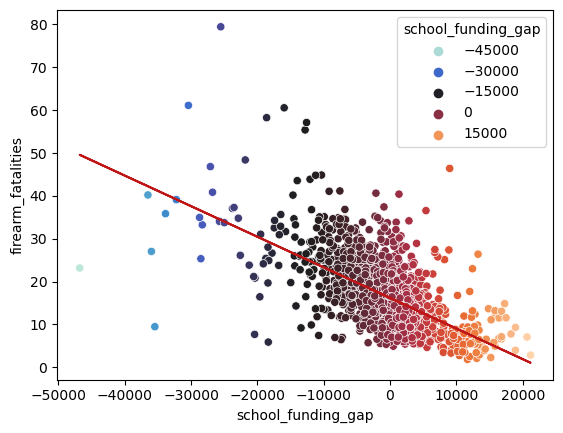

In [29]:
poly_reg_line(X_1, y_2, slope_2, intercept_2)

#### Life Expectancy

In [30]:
model_3= smf.ols(formula='life_expectancy ~ school_funding_gap', data=agg_select_subset).fit()
intercept_3 = model_3.params.Intercept
slope_3 = model_3.params.school_funding_gap
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     770.7
Date:                Wed, 14 May 2025   Prob (F-statistic):          1.86e-139
Time:                        15:43:03   Log-Likelihood:                -3951.1
No. Observations:                1648   AIC:                             7906.
Df Residuals:                    1646   BIC:                             7917.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             75.0806      0.066   1135.971      0.000      74.951      75.210
school_funding_gap     0.0003   1.02e-05     27.762      0.000       0.000       0.000
==============================================================================
Omnibus:                       32.940   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.169
Skew:                           0.164   Prob(JB):                     1.73e-12
Kurtosis:                       3.825   Cond. No.                     6.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

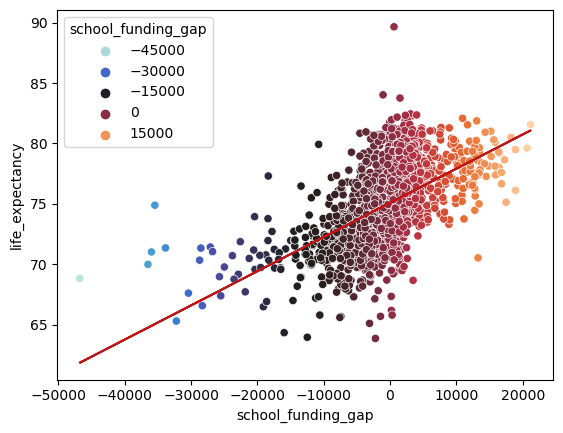

In [31]:
poly_reg_line(X_1, y_4, slope_3, intercept_3)

### Income Inequality 

In [32]:
model_4= smf.ols(formula='life_expectancy ~ income_inequality', data=agg_select_subset).fit()
intercept_4 = model_4.params.Intercept
slope_4 = model_4.params.income_inequality
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     438.3
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.77e-86
Time:                        15:43:23   Log-Likelihood:                -4073.1
No. Observations:                1648   AIC:                             8150.
Df Residuals:                    1646   BIC:                             8161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            84.4045      0.462    182.818      0.000      83.499      85.310
income_inequality    -2.0759      0.099    -20.936      0.000      -2.270      -1.881
==============================================================================
Omnibus:                       61.467   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.640
Skew:                           0.392   Prob(JB):                     5.09e-18
Kurtosis:                       3.738   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

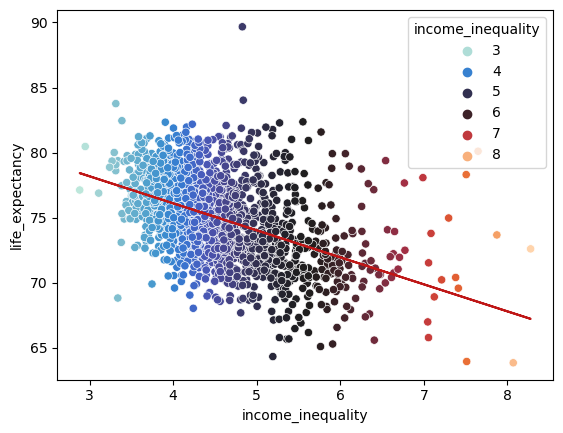

In [33]:
poly_reg_line(X_2, y_4, slope_4, intercept_4)

#### Child Poverty

In [34]:
model_5= smf.ols(formula='child_poverty_percentage ~ income_inequality', data=agg_select_subset).fit()
intercept_5 = model_5.params.Intercept
slope_5 = model_5.params.income_inequality
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     child_poverty_percentage   R-squared:                       0.388
Model:                                  OLS   Adj. R-squared:                  0.387
Method:                       Least Squares   F-statistic:                     1042.
Date:                      Wed, 14 May 2025   Prob (F-statistic):          1.63e-177
Time:                              15:43:52   Log-Likelihood:                 2299.8
No. Observations:                      1648   AIC:                            -4596.
Df Residuals:                          1646   BIC:                            -4585.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1197      0.010    -12.393      0.000      -0.139      -0.101
income_inequality     0.0670      0.002     32.279      0.000       0.063       0.071
==============================================================================
Omnibus:                      176.199   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.080
Skew:                           0.585   Prob(JB):                    3.76e-102
Kurtosis:                       5.331   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

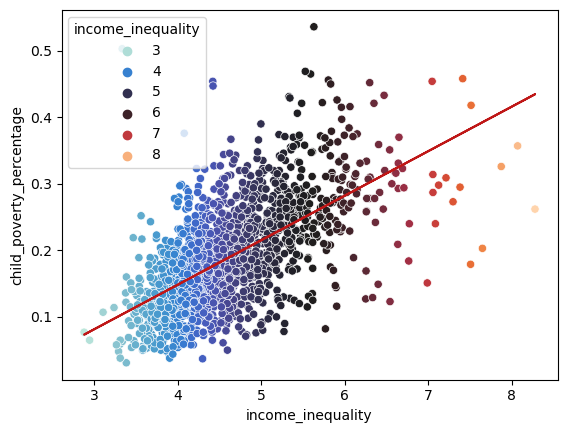

In [35]:
poly_reg_line(X_2, y_1, slope_5, intercept_5)

#### Median Income

In [36]:
model_6= smf.ols(formula='median_income ~ income_inequality', data=agg_select_subset).fit()
intercept_6 = model_6.params.Intercept
slope_6 = model_6.params.income_inequality
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          median_income   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     557.6
Date:                Wed, 14 May 2025   Prob (F-statistic):          2.08e-106
Time:                        15:44:01   Log-Likelihood:                -18100.
No. Observations:                1648   AIC:                         3.620e+04
Df Residuals:                    1646   BIC:                         3.622e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.209e+05   2295.998     52.664      0.000    1.16e+05    1.25e+05
income_inequality -1.164e+04    493.112    -23.613      0.000   -1.26e+04   -1.07e+04
==============================================================================
Omnibus:                      328.592   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              638.391
Skew:                           1.184   Prob(JB):                    2.37e-139
Kurtosis:                       4.922   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

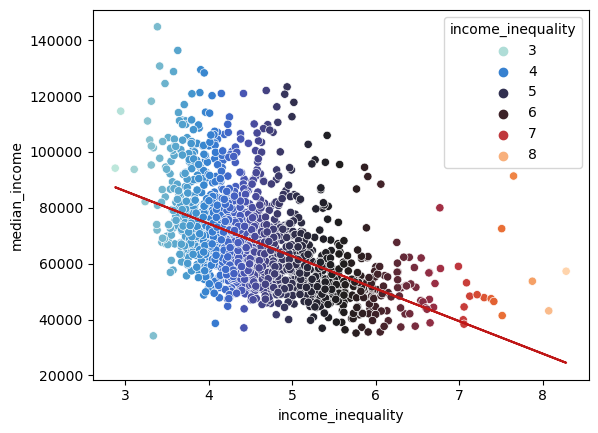

In [37]:
poly_reg_line(X_2, y_3, slope_6, intercept_6)

## Multiple Regression

In [ ]:
# vs child poverty
import statsmodels.api as sm

# X contains multiple predictors
X_m = agg_select_subset[['school_funding_gap', 'income_inequality']]
#y_1 = agg_select_subset['child_poverty_percentage']

X_m = sm.add_constant(X_m)  # Adds intercept
model_m = sm.OLS(y_1, X_m).fit()
print(model_m.summary())


                               OLS Regression Results                               
Dep. Variable:     child_poverty_percentage   R-squared:                       0.588
Model:                                  OLS   Adj. R-squared:                  0.587
Method:                       Least Squares   F-statistic:                     1172.
Date:                      Wed, 14 May 2025   Prob (F-statistic):          3.27e-317
Time:                              15:46:35   Log-Likelihood:                 2625.8
No. Observations:                      1648   AIC:                            -5246.
Df Residuals:                          1645   BIC:                            -5229.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [ ]:
# vs firearm fatalities
model_m2 = sm.OLS(y_2, X_m).fit()
print(model_m2.summary())


                            OLS Regression Results                            
Dep. Variable:     firearm_fatalities   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     530.6
Date:                Wed, 14 May 2025   Prob (F-statistic):          1.56e-178
Time:                        18:12:55   Log-Likelihood:                -5269.7
No. Observations:                1648   AIC:                         1.055e+04
Df Residuals:                    1645   BIC:                         1.056e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.6119      1

In [109]:
# vs median income
model_m3 = sm.OLS(y_3, X_m).fit()
print(model_m3.summary())


                            OLS Regression Results                            
Dep. Variable:          median_income   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     482.7
Date:                Wed, 14 May 2025   Prob (F-statistic):          1.11e-165
Time:                        18:14:31   Log-Likelihood:                -17960.
No. Observations:                1648   AIC:                         3.593e+04
Df Residuals:                    1645   BIC:                         3.594e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                1.08e+05   2234

In [110]:
# vs life expectancy
model_m4 = sm.OLS(y_4, X_m).fit()
print(model_m4.summary())


                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     540.1
Date:                Wed, 14 May 2025   Prob (F-statistic):          4.85e-181
Time:                        18:16:45   Log-Likelihood:                -3851.6
No. Observations:                1648   AIC:                             7709.
Df Residuals:                    1645   BIC:                             7726.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 81.2284      0

In [111]:
# vs premature death
model_m5 = sm.OLS(y_5, X_m).fit()
print(model_m5.summary())


                            OLS Regression Results                            
Dep. Variable:        premature_death   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     661.0
Date:                Wed, 14 May 2025   Prob (F-statistic):          2.05e-211
Time:                        18:17:31   Log-Likelihood:                -15211.
No. Observations:                1648   AIC:                         3.043e+04
Df Residuals:                    1645   BIC:                         3.044e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2738.5979    421

### Modeling multivar- child poverty

In [ ]:
x_m1 = agg_select_subset[['school_funding_gap', 'income_inequality']].values.reshape(-1, 2)
x = x_m1[:, 0]
y = x_m1[:, 1]
z = y_1

In [ ]:
ols = linear_model.LinearRegression()
model_m1 = ols.fit(x_m1, y_1)
predicted = model_m1.predict(model_viz)

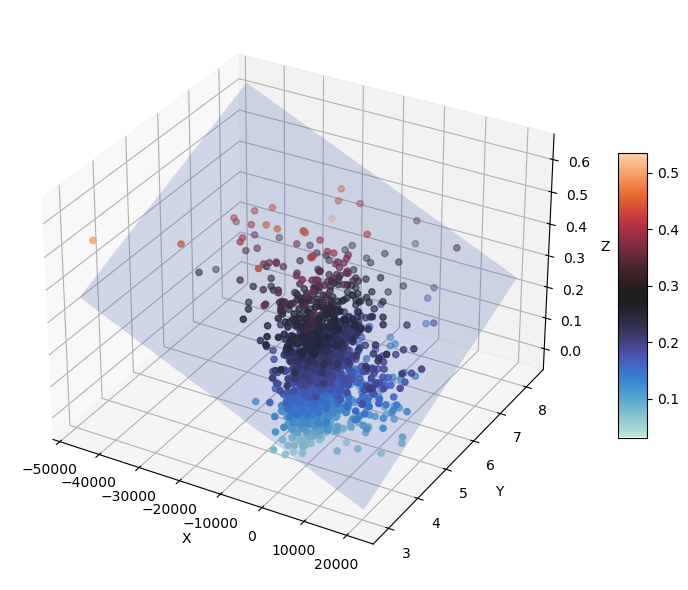

In [107]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create a clean meshgrid
x_surf = np.linspace(x.min(), x.max(), 20)
y_surf = np.linspace(y.min(), y.max(), 20)
x_plane, y_plane = np.meshgrid(x_surf, y_surf)
z_plane = plane_coef[0] * x_plane + plane_coef[1] * y_plane + plane_coef[2]

# Plot the plane
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.2, color='royalblue')

# Plot the scatter
scatter = ax.scatter(x, y, z, c=z, cmap='icefire')

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


## Polynomial

### Joint Effects

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Fit child poverty vs school funding gap as a polynomial regression
#X = agg_select_subset[['school_funding_gap', 'income_inequality']]
#y = agg_select_subset['child_poverty_percentage']

# Try 2nd or 3rd degree
model_p = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model_p.fit(X_m, y_1)

# Predict and evaluate
y_pred_p = model_p.predict(X_m)

# Interaction Terms

In [40]:
agg_select_subset['interaction'] = agg_select_subset['school_funding_gap'] * agg_select_subset['income_inequality']
X_agg = agg_select_subset[['school_funding_gap', 'income_inequality', 'interaction']]
#y = agg_select_subset['child_poverty_percentage']

X_agg = sm.add_constant(X_agg)
model_agg = sm.OLS(y_1, X_agg).fit()
print(model_agg.summary())

                               OLS Regression Results                               
Dep. Variable:     child_poverty_percentage   R-squared:                       0.590
Model:                                  OLS   Adj. R-squared:                  0.590
Method:                       Least Squares   F-statistic:                     790.1
Date:                      Wed, 14 May 2025   Prob (F-statistic):          5.02e-318
Time:                              15:52:28   Log-Likelihood:                 2631.3
No. Observations:                      1648   AIC:                            -5255.
Df Residuals:                          1644   BIC:                            -5233.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [41]:
interaction_df = agg_select_subset.copy()

### Interaction Heatmap

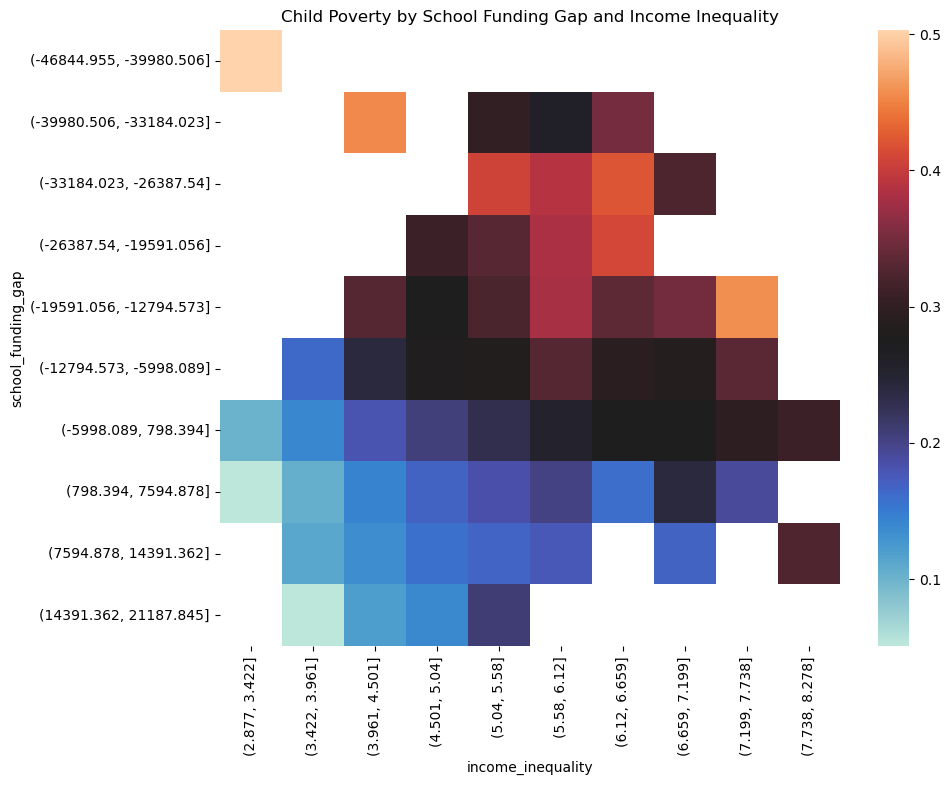

In [42]:
interaction_df['child_poverty_bin'] = pd.cut(interaction_df['child_poverty_percentage'], bins=10)
pivot = interaction_df.pivot_table(values='child_poverty_percentage',
                       index=pd.cut(interaction_df['school_funding_gap'], 10),
                       columns=pd.cut(interaction_df['income_inequality'], 10),
                       aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, cmap='icefire', annot=False)
plt.title("Child Poverty by School Funding Gap and Income Inequality")
plt.show()


# Group Observations

## Defining Groups

In [43]:
grouped_df = agg_select_subset.copy()
# adding column with inequality quantile 
grouped_df['quartile_income_inequality'] = pd.qcut(grouped_df['income_inequality'], q=4, labels=False)
# adding column defining whether county meets federal school funding requirements
grouped_df['meeting_school_funding_requirement'] = np.where(grouped_df['school_funding_gap']>=0, 'yes', 'no')
school_funding_grouped = grouped_df.groupby('meeting_school_funding_requirement')
income_inequality_grouped = grouped_df.groupby('quartile_income_inequality')

In [ ]:
#grouped_df.to_csv('grouped_df.csv', index=False)

### Descriptive Stats Accross Groups

In [45]:
school_funding_grouped.describe().round(2)

school_funding_gap                    \
                                                count     mean      std   
meeting_school_funding_requirement                                        
no                                              875.0 -4815.79  5483.21   
yes                                             773.0  3735.09  3906.57   

                                                                        \
                                         min      25%      50%     75%   
meeting_school_funding_requirement                                       
no                                 -46776.99 -6134.39 -3126.54 -1410.7   
yes                                     1.63  1182.52  2472.09  4430.5   

                                             child_poverty_percentage        \
                                         max                    count  mean   
meeting_school_funding_requirement                                            
no                                     -0.25                    875.0  0.23   
yes                                 21187.84                    773.0  0.15   

                                    ... interaction            \
                                    ...         75%       max   
meeting_school_funding_requirement  ...                         
no                                  ...    -6348.65     -1.00   
yes                                 ...    19299.26  97191.05   

                                   quartile_income_inequality              \
                                                        count  mean   std   
meeting_school_funding_requirement                                          
no                                                      875.0  1.80  1.09   
yes                                                     773.0  1.15  1.05   

                                                             
                                    min  25%  50%  75%  max  
meeting_school_funding_requirement                           
no                                  0.0  1.0  2.0  3.0  3.0  
yes                                 0.0  0.0  1.0  2.0  3.0  

[2 rows x 72 columns]

In [46]:
income_inequality_grouped.describe().round(2)

school_funding_gap                              \
                                        count     mean      std       min   
quartile_income_inequality                                                  
0                                       415.0  1283.16  4454.76 -46776.99   
1                                       410.0   343.50  5061.11 -33847.18   
2                                       411.0  -253.23  5797.63 -23516.77   
3                                       412.0 -4601.62  8132.18 -36495.30   

                                                                 \
                                25%      50%      75%       max   
quartile_income_inequality                                        
0                           -797.90  1261.39  3061.95  18231.33   
1                          -2316.61   134.71  2460.44  21187.84   
2                          -3365.77  -524.42  2039.25  18898.09   
3                          -7886.41 -3698.88    20.30  18897.74   

                           child_poverty_percentage        ...  \
                                              count  mean  ...   
quartile_income_inequality                                 ...   
0                                             415.0  0.13  ...   
1                                             410.0  0.17  ...   
2                                             411.0  0.20  ...   
3                                             412.0  0.26  ...   

                           premature_death           interaction            \
                                       75%       max       count      mean   
quartile_income_inequality                                                   
0                                  9670.95  19407.34       415.0   5012.92   
1                                 11381.38  18377.17       410.0   1453.35   
2                                 12661.47  18735.53       411.0  -1268.05   
3                                 14843.19  27851.41       412.0 -26462.66   

                                                                               \
                                 std        min       25%       50%       75%   
quartile_income_inequality                                                      
0                           16748.10 -156141.59  -3027.39   5038.26  11508.56   
1                           21836.77 -149672.23  -9974.14    577.93  10636.40   
2                           27434.36 -116455.05 -15957.78  -2507.26   9624.44   
3                           47086.98 -238642.77 -43117.23 -19877.90    103.57   

                                      
                                 max  
quartile_income_inequality            
0                           70701.10  
1                           87971.93  
2                           88046.19  
3                           97191.05  

[4 rows x 64 columns]

## Group Pair Plots

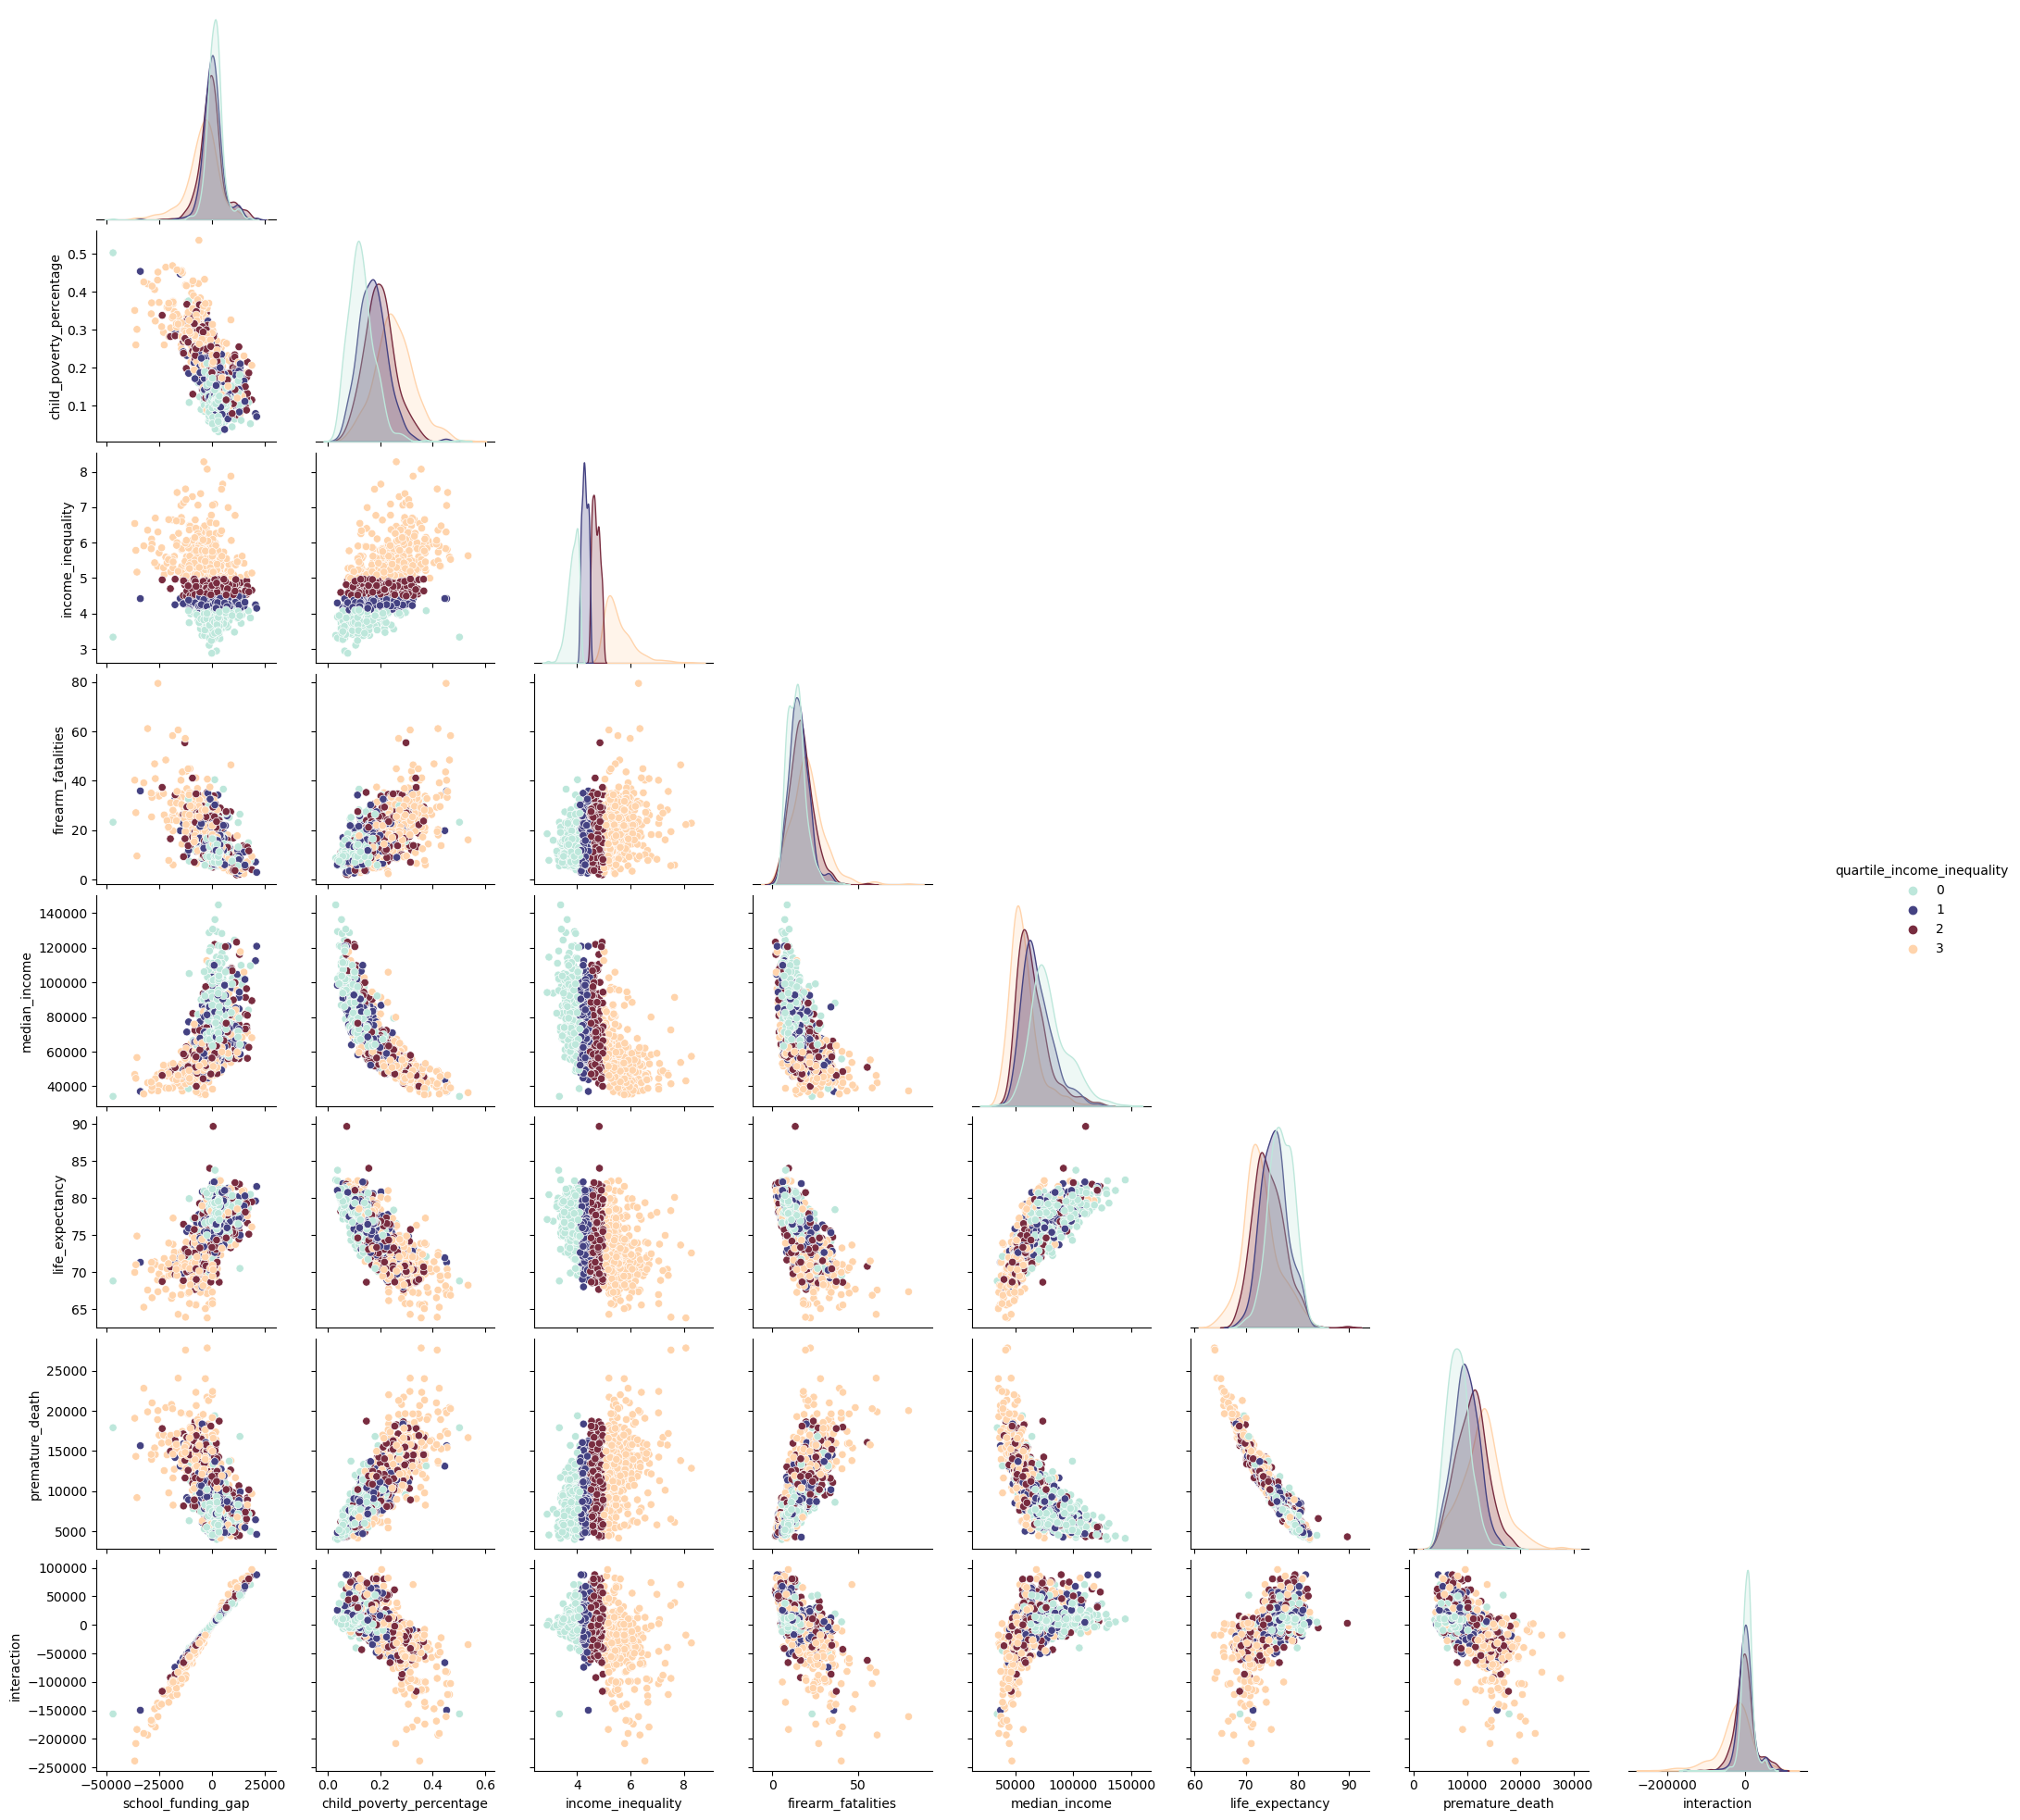

In [47]:
sns.pairplot(grouped_df, hue='quartile_income_inequality', palette='icefire', corner=True)
plt.show()

#### Across Schools Meeting Federal School Funding Requirements per pupil and those failing to meet them 

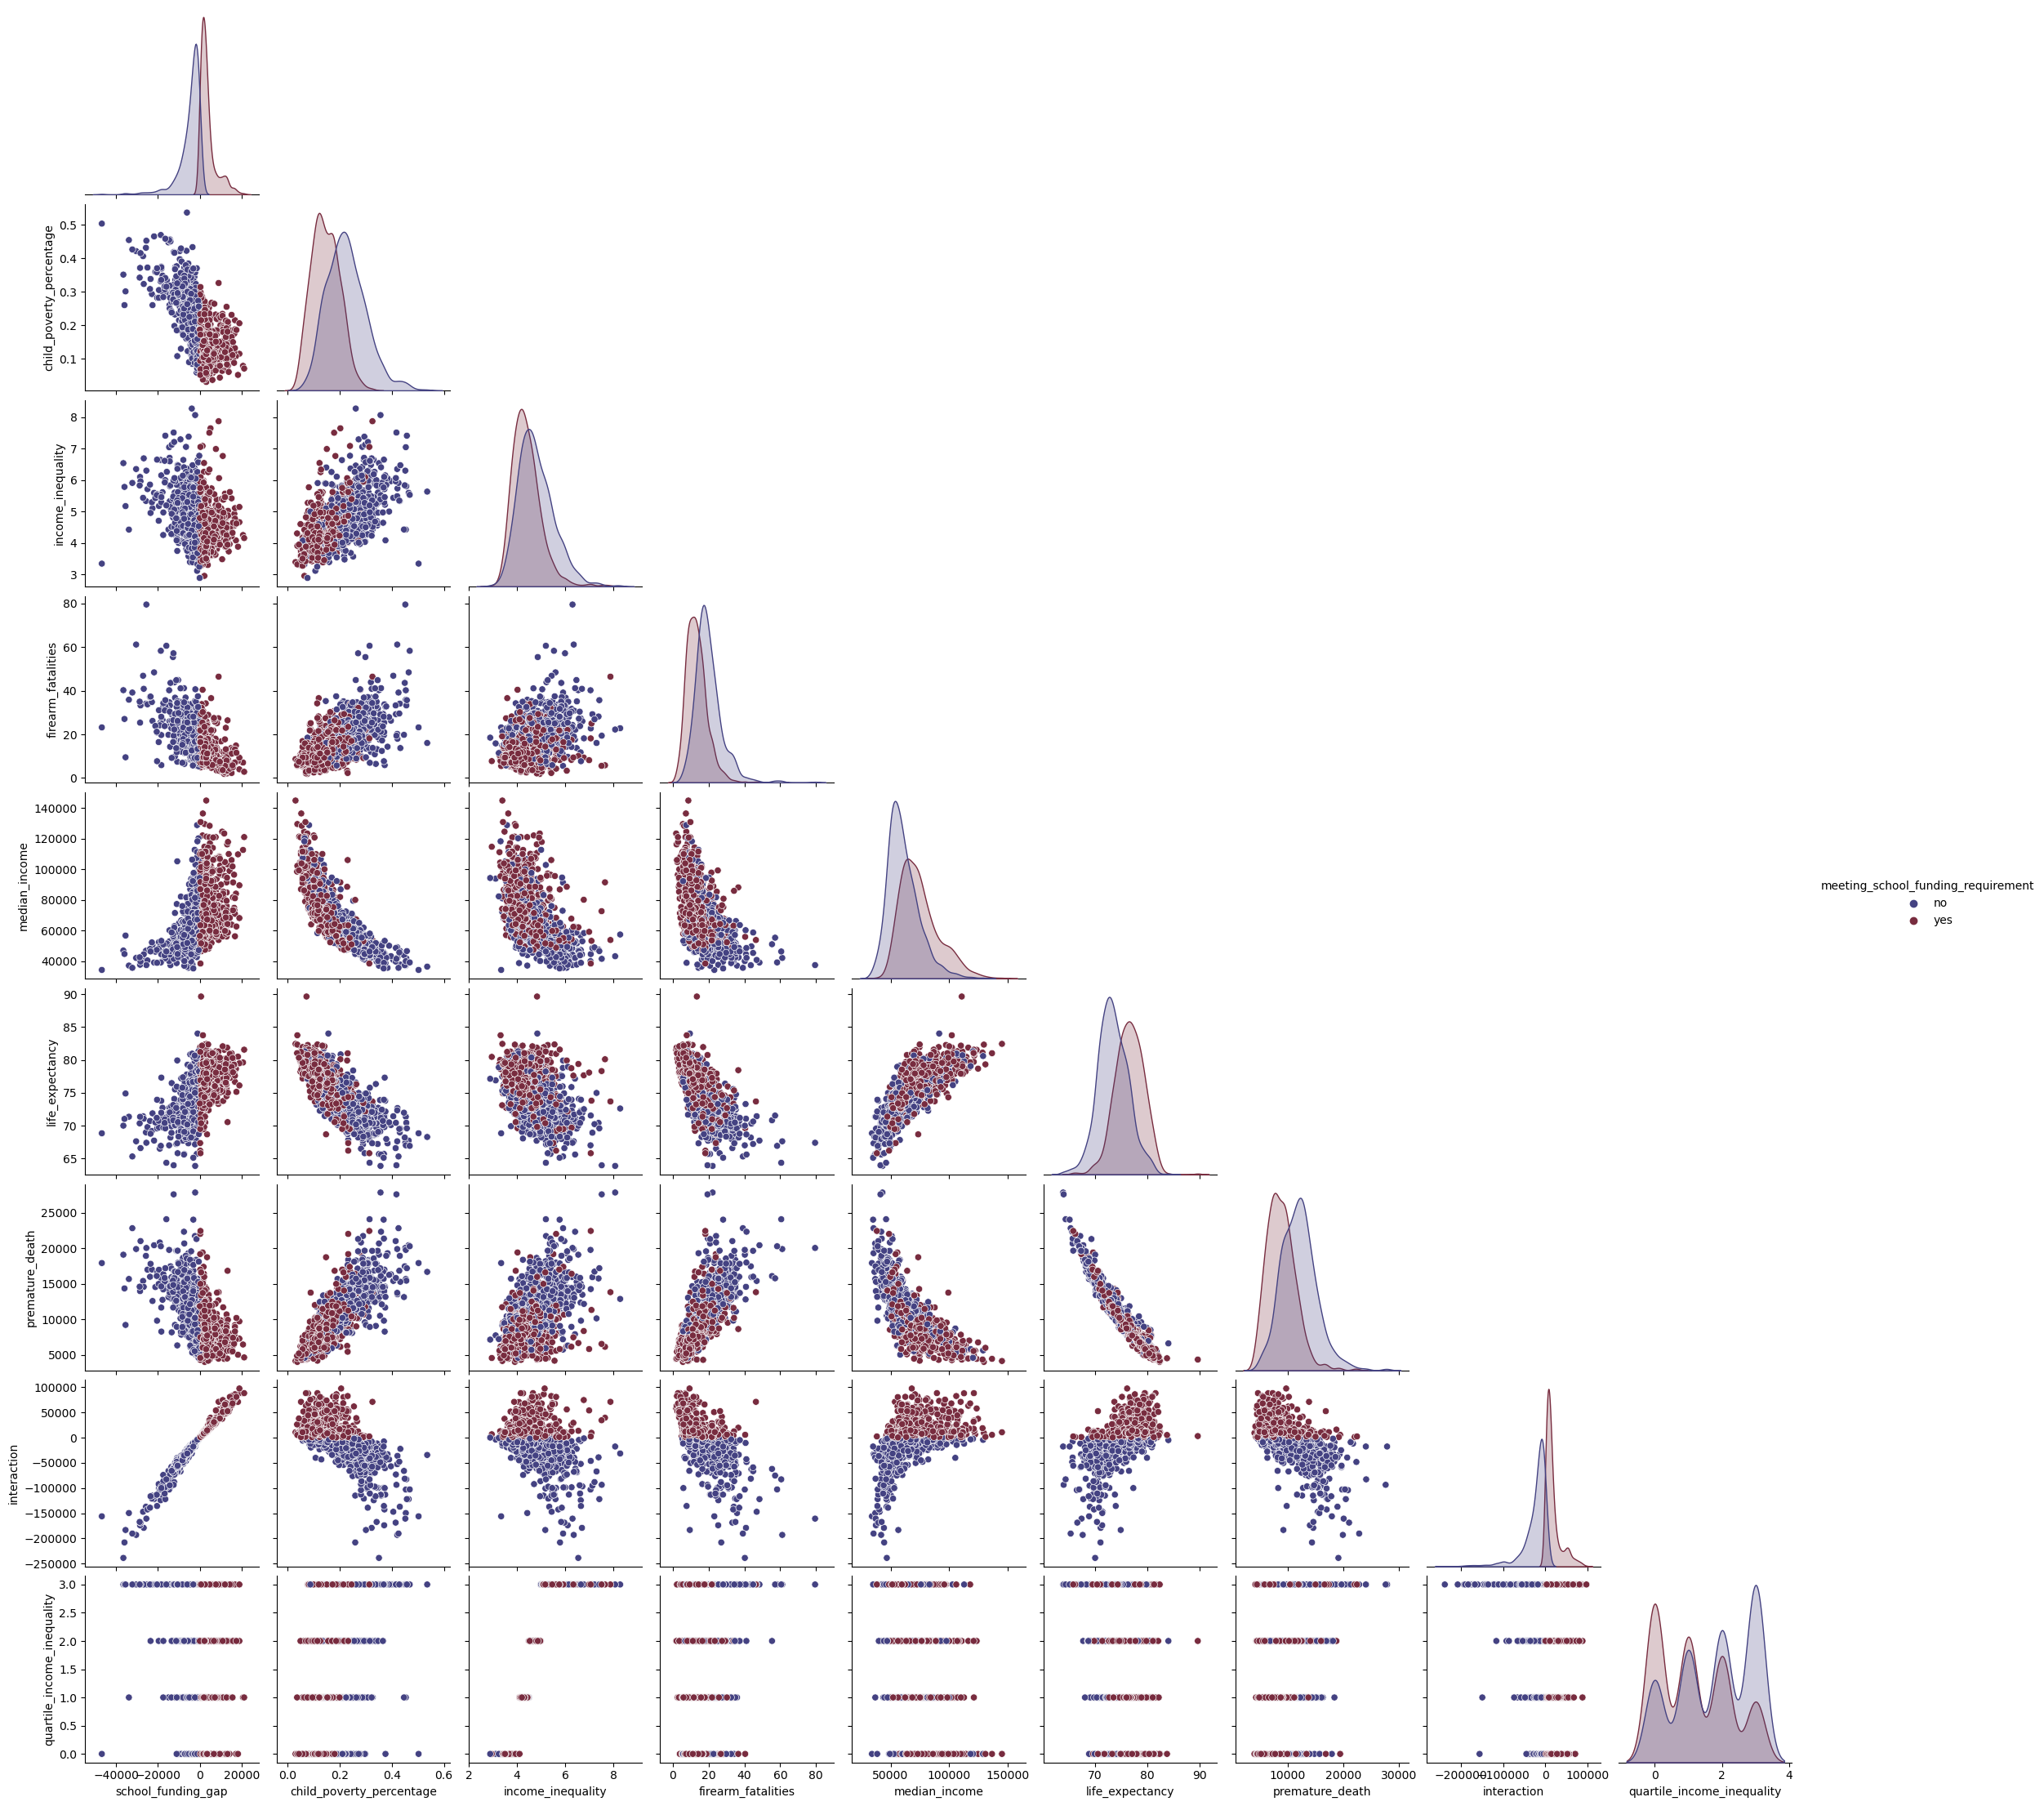

In [48]:
sns.pairplot(grouped_df, hue='meeting_school_funding_requirement', palette='icefire', corner=True)
plt.show()

# Statistical Testing- Differences accross groups

## Comparing Means

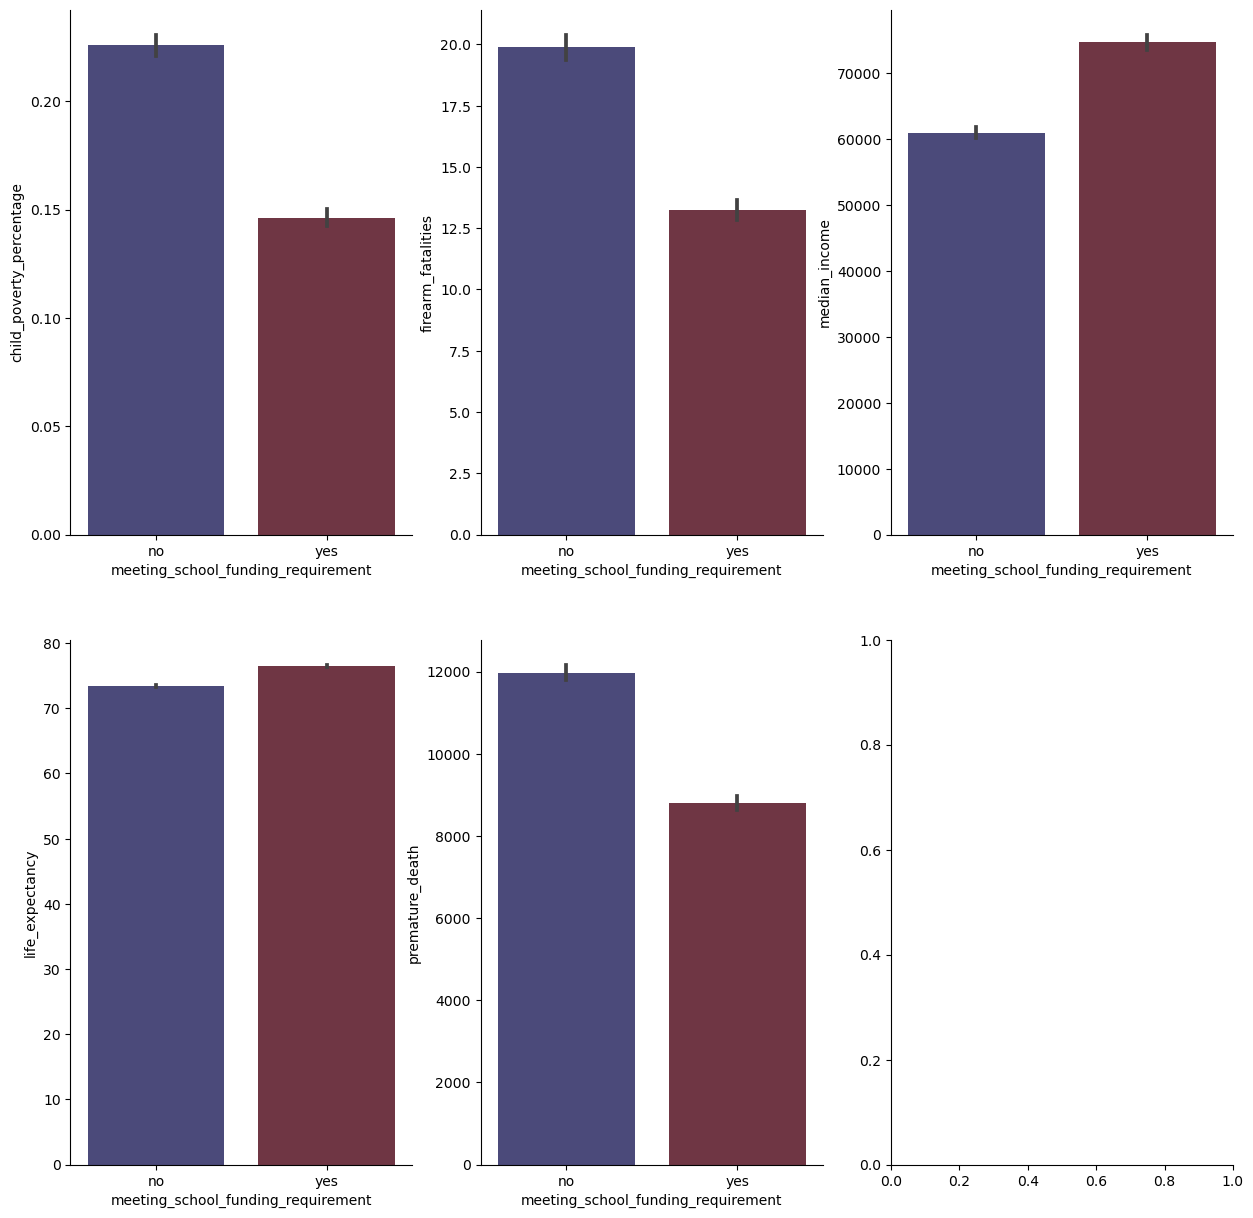

In [49]:
#sns.set(style='dark')
fig, axes = plt.subplots(2,3, figsize=(15, 15))
palette=sns.color_palette('icefire', 2)
sns.barplot(x='meeting_school_funding_requirement', y = 'child_poverty_percentage', data = grouped_df, ax=axes[0,0], palette=palette) 
sns.barplot(x='meeting_school_funding_requirement', y = 'firearm_fatalities', data = grouped_df, ax=axes[0,1], palette=palette)
sns.barplot(x='meeting_school_funding_requirement', y = 'median_income', data = grouped_df, ax=axes[0,2], palette=palette)
sns.barplot(x='meeting_school_funding_requirement', y = 'life_expectancy', data = grouped_df, ax=axes[1,0], palette=palette)
sns.barplot(x='meeting_school_funding_requirement', y = 'premature_death', data = grouped_df, ax=axes[1,1], palette=palette)
sns.despine()
plt.show()

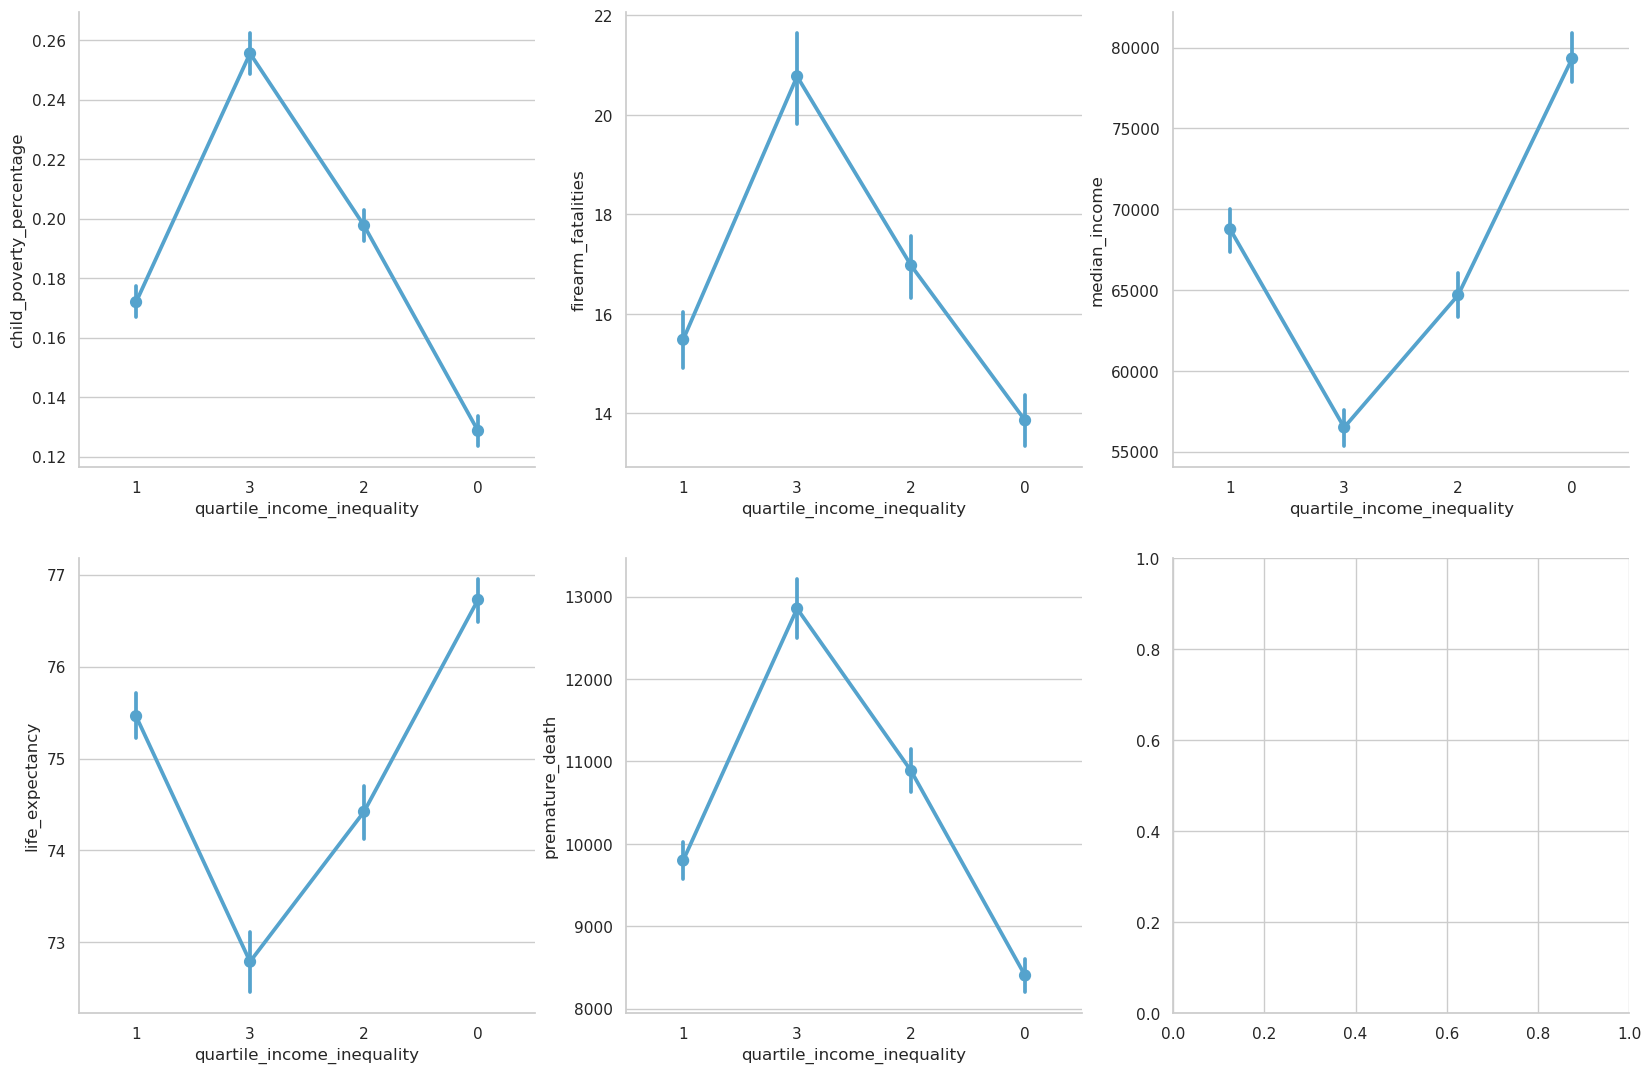

In [255]:

fig, axes = plt.subplots(2,3, figsize=(20, 13))
palette=sns.color_palette('icefire', 2)
sns.pointplot(x='quartile_income_inequality', y = 'child_poverty_percentage', data = grouped_df, ax=axes[0,0])
sns.pointplot(x='quartile_income_inequality', y = 'firearm_fatalities', data = grouped_df, ax=axes[0,1])
sns.pointplot(x='quartile_income_inequality', y = 'median_income', data = grouped_df, ax=axes[0,2])
sns.pointplot(x='quartile_income_inequality', y = 'life_expectancy', data = grouped_df, ax=axes[1,0])
sns.pointplot(x='quartile_income_inequality', y = 'premature_death', data = grouped_df, ax=axes[1,1])
sns.despine()
plt.show()

## Hypothesis
$H_{01}$ Counties that meet school funding requirements and those that do not have no difference in mean accross selected socio-economic metrics

$H_{02}$ Counties across all for quartiles of income inequality have no difference in mean accross selected socio-economic metrics

$H_{A1}$ There is a difference in mean between counties that meet school funding requirements and those that do not

$H_{A2}$ There is a difference in mean between Counties across all for quartiles of income inequality

## Chi-Squared Testing

In [50]:
from scipy.stats import chi2_contingency
# Defining a function to perform the Chi-Square Test and interpret results
def perform_chi_square_test(data, col1, col2):
    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant

# Additional aspects to test 
additional_aspects_to_test = {
    'Whether School meets required federal funding and child poverty': ('meeting_school_funding_requirement', 'child_poverty_percentage'),
    'Whether School meets required federal funding and firearm fatalities': ('meeting_school_funding_requirement', 'firearm_fatalities'),
    'Whether School meets required federal funding and life expectancy': ('meeting_school_funding_requirement', 'life_expectancy'),
    'Whether School meets required federal funding and median income': ('meeting_school_funding_requirement', 'median_income'),
    'Whether School meets required federal funding and premature death': ('meeting_school_funding_requirement', 'premature_death'),
    'Income Inequality Quartile and child poverty': ('quartile_income_inequality', 'child_poverty_percentage'),
    'Income Inequality Quartile and firearm fatalities': ('quartile_income_inequality', 'firearm_fatalities'),
    'Income Inequality Quartile and life expectancy': ('quartile_income_inequality', 'life_expectancy'),
    'Income Inequality Quartile and median income': ('quartile_income_inequality', 'median_income'),
    'Income Inequality Quartile and premature death': ('quartile_income_inequality', 'premature_death'),
    'Political Party and child poverty': ('political_party', 'child_poverty_percentage'),
    'Political Party and firearm fatalities': ('political_party', 'firearm_fatalities'),
    'Political Party and life expectancy': ('political_party', 'life_expectancy'),
    'Political Party and median income': ('political_party', 'median_income'),
    'Political Party and premature death': ('political_party', 'premature_death'),
}


In [51]:
additional_mat_chi_square_results = {aspect: perform_chi_square_test(grouped_df, *columns) for aspect, columns in additional_aspects_to_test.items()}
additional_mat_chi_square_results

{'Whether School meets required federal funding and child poverty': (np.float64(653.4111500985841),
  np.float64(1.2842473003621774e-22),
  np.True_),
 'Whether School meets required federal funding and firearm fatalities': (np.float64(1589.1077306720877),
  np.float64(0.4451122833120476),
  np.False_),
 'Whether School meets required federal funding and life expectancy': (np.float64(1581.076966672827),
  np.float64(0.31669809901063806),
  np.False_),
 'Whether School meets required federal funding and median income': (np.float64(1621.2307866691308),
  np.float64(0.47970268362438123),
  np.False_),
 'Whether School meets required federal funding and premature death': (np.float64(1648.0),
  np.float64(0.48841810656984014),
  np.False_),
 'Income Inequality Quartile and child poverty': (np.float64(1538.0970210044675),
  np.float64(8.140812283636531e-25),
  np.True_),
 'Income Inequality Quartile and firearm fatalities': (np.float64(4754.5868023992),
  np.float64(0.4621873864586245),
  np

In [52]:
grouped_df.groupby('meeting_school_funding_requirement').mean(numeric_only=True).round(2)

school_funding_gap  \
meeting_school_funding_requirement                       
no                                            -4815.79   
yes                                            3735.09   

                                    child_poverty_percentage  \
meeting_school_funding_requirement                             
no                                                      0.23   
yes                                                     0.15   

                                    income_inequality  firearm_fatalities  \
meeting_school_funding_requirement                                          
no                                               4.79               19.88   
yes                                              4.39               13.24   

                                    median_income  life_expectancy  \
meeting_school_funding_requirement                                   
no                                       60897.16            73.39   
yes                                      74628.61            76.50   

                                    premature_death  interaction  \
meeting_school_funding_requirement                                 
no                                         11972.43    -24698.98   
yes                                         8795.87     16641.74   

                                    quartile_income_inequality  
meeting_school_funding_requirement                              
no                                                        1.80  
yes                                                       1.15

In [53]:
grouped_df.groupby('quartile_income_inequality').mean(numeric_only=True).round(2)

school_funding_gap  child_poverty_percentage  \
quartile_income_inequality                                                 
0                                      1283.16                      0.13   
1                                       343.50                      0.17   
2                                      -253.23                      0.20   
3                                     -4601.62                      0.26   

                            income_inequality  firearm_fatalities  \
quartile_income_inequality                                          
0                                        3.83               13.86   
1                                        4.29               15.48   
2                                        4.71               16.97   
3                                        5.57               20.77   

                            median_income  life_expectancy  premature_death  \
quartile_income_inequality                                                    
0                                79320.61            76.73          8403.42   
1                                68757.31            75.46          9797.68   
2                                64685.21            74.42         10886.34   
3                                56501.83            72.79         12855.18   

                            interaction  
quartile_income_inequality               
0                               5012.92  
1                               1453.35  
2                              -1268.05  
3                             -26462.66

In [252]:
school_funding_table = grouped_df.groupby('meeting_school_funding_requirement').mean(numeric_only=True).round(3)

Since are values are not normally distrubuted, we will attempt a non-parametric multivariate method

# PERMANOVA

In [54]:
# must convert to sring to encode as one group variable
grouped_df['meeting_school_funding_requirement'] = grouped_df['meeting_school_funding_requirement'].astype('str')
grouped_df['quartile_income_inequality'] = grouped_df['quartile_income_inequality'].astype('str')

In [55]:
# encoding group varoable
grouped_df['group'] = grouped_df['meeting_school_funding_requirement'] + "_Q" + grouped_df['quartile_income_inequality'].astype(str)

In [56]:
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform

In [57]:
grouped_df.head()

state_abbr          county  fips  school_funding_gap  \
0         AL  Autauga County  1001           -2319.660   
1         AL  Baldwin County  1003             506.300   
2         AL  Barbour County  1005          -17790.455   
3         AL     Bibb County  1007           -3657.800   
4         AL   Blount County  1009           -1559.425   

   child_poverty_percentage  income_inequality  firearm_fatalities  \
0                     0.170              4.274              17.454   
1                     0.141              4.360              14.962   
2                     0.348              5.614              26.650   
3                     0.214              5.347              21.542   
4                     0.166              4.620              18.145   

   median_income  life_expectancy  premature_death political_party  \
0        68857.0           74.801         9938.263               R   
1        74248.0           76.580         8957.113               R   
2        45298.0           72.709        12738.656               R   
3        56025.0           72.977        11708.948               R   
4        64962.0           72.936        11898.088               R   

   interaction quartile_income_inequality meeting_school_funding_requirement  \
0  -9914.22684                          1                                 no   
1   2207.46800                          1                                yes   
2 -99875.61437                          3                                 no   
3 -19558.25660                          3                                 no   
4  -7204.54350                          2                                 no   

    group  
0   no_Q1  
1  yes_Q1  
2   no_Q3  
3   no_Q3  
4   no_Q2

In [ ]:
#grouped_df.to_csv('grouped_df.csv', index=False)

In [59]:
# fixing indexing error 
cols_needed = ['fips', 'group', 'child_poverty_percentage', 'firearm_fatalities',
               'median_income', 'life_expectancy', 'premature_death']
df_clean = grouped_df.dropna(subset=cols_needed).copy()

# Ensuring FIPS is str and unique
df_clean['fips'] = df_clean['fips'].astype(str)
df_clean = df_clean.drop_duplicates(subset='fips')

#  Extracting outcome matrix and ensure alignment
X = df_clean[['child_poverty_percentage', 'firearm_fatalities',
              'median_income', 'life_expectancy', 'premature_death']].values
ids = df_clean['fips'].tolist()

In [62]:
distance_matrix = squareform(pdist(X, metric='euclidean'))

# Create DistanceMatrix
dm = DistanceMatrix(distance_matrix, ids=ids)

# Align grouping series using fips as index
grouping_series = df_clean.set_index('fips').reindex(dm.ids)['group']


# Run PERMANOVA
result = permanova(dm, grouping_series, permutations=999)
print(result)

method name                PERMANOVA
test statistic name         pseudo-F
sample size                     1648
number of groups                   8
test statistic            118.046529
p-value                        0.001
number of permutations           999
Name: PERMANOVA results, dtype: object


In [116]:
with open("permanova_summary.txt", "w") as f:
    f.write(str(result))


In [63]:
from itertools import combinations

def pairwise_permanova(df, outcome_cols, group_col, id_col='id', permutations=999):
    results = []
    groups = df[group_col].unique()

    for g1, g2 in combinations(groups, 2):
        subset = df[df[group_col].isin([g1, g2])].copy()
        X = subset[outcome_cols].values
        ids = subset[id_col].astype(str).values

        # Ensure IDs are unique
        subset = subset.drop_duplicates(subset=id_col)
        X = subset[outcome_cols].values
        ids = subset[id_col].astype(str).values

        # Compute distance matrix and run PERMANOVA
        dist_matrix = squareform(pdist(X, metric='euclidean'))
        dm = DistanceMatrix(dist_matrix, ids)
        grouping_series = subset.set_index(id_col).reindex(dm.ids)[group_col]

        result = permanova(dm, grouping_series, permutations=permutations)

        results.append({
            'Group 1': g1,
            'Group 2': g2,
            'Test Statistic': result['test statistic'],
            'p-value': result['p-value'],
            'Permutations': permutations
        })

    results_df = pd.DataFrame(results)
    results_df['p-value (adjusted)'] = results_df['p-value'] * len(results_df)  # Bonferroni correction
    results_df['Significant (α=0.05)'] = results_df['p-value (adjusted)'] < 0.05
    return results_df

In [64]:
pairwise_results= pairwise_permanova(df_clean, y_vars, 'group', id_col='fips', permutations=999)

In [65]:
from IPython.display import display
display(pairwise_results.sort_values(by='p-value (adjusted)'))
#pairwise_results.to_csv('pairwise_permanova_results.csv', index=False)

Group 1 Group 2  Test Statistic  p-value  Permutations  p-value (adjusted)  \
0    no_Q1  yes_Q1       37.593351    0.001           999               0.028   
1    no_Q1   no_Q3      141.646828    0.001           999               0.028   
2    no_Q1   no_Q2       19.466145    0.001           999               0.028   
3    no_Q1  yes_Q2       16.540495    0.001           999               0.028   
4    no_Q1   no_Q0       36.248175    0.001           999               0.028   
5    no_Q1  yes_Q0      163.605615    0.001           999               0.028   
7   yes_Q1   no_Q3      346.356285    0.001           999               0.028   
8   yes_Q1   no_Q2      117.680430    0.001           999               0.028   
15   no_Q3   no_Q0      284.718193    0.001           999               0.028   
11  yes_Q1  yes_Q0       48.459792    0.001           999               0.028   
14   no_Q3  yes_Q2      221.252954    0.001           999               0.028   
13   no_Q3   no_Q2       62.157953    0.001           999               0.028   
19   no_Q2   no_Q0      103.790562    0.001           999               0.028   
18   no_Q2  yes_Q2       65.577946    0.001           999               0.028   
17   no_Q3  yes_Q3      108.169124    0.001           999               0.028   
16   no_Q3  yes_Q0      687.668435    0.001           999               0.028   
27  yes_Q0  yes_Q3       73.886449    0.001           999               0.028   
26   no_Q0  yes_Q3       13.511569    0.001           999               0.028   
23  yes_Q2  yes_Q0       56.406424    0.001           999               0.028   
25   no_Q0  yes_Q0       26.800836    0.001           999               0.028   
20   no_Q2  yes_Q0      317.776314    0.001           999               0.028   
21   no_Q2  yes_Q3       21.500252    0.001           999               0.028   
12  yes_Q1  yes_Q3       12.773119    0.002           999               0.056   
24  yes_Q2  yes_Q3        4.578714    0.038           999               1.064   
22  yes_Q2   no_Q0        3.115132    0.076           999               2.128   
9   yes_Q1  yes_Q2        1.742812    0.202           999               5.656   
6    no_Q1  yes_Q3        1.348328    0.246           999               6.888   
10  yes_Q1   no_Q0        0.819652    0.343           999               9.604   

    Significant (α=0.05)  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True  
5                   True  
7                   True  
8                   True  
15                  True  
11                  True  
14                  True  
13                  True  
19                  True  
18                  True  
17                  True  
16                  True  
27                  True  
26                  True  
23                  True  
25                  True  
20                  True  
21                  True  
12                 False  
24                 False  
22                 False  
9                  False  
6                  False  
10                 False

## PERMANOVA Heatmaps

In [66]:
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import TwoSlopeNorm, ListedColormap

# Normalize around 0.05 for diverging effect
norm = TwoSlopeNorm(vmin=0, vcenter=4.0, vmax=10)
pval_palette = sns.color_palette(palette='icefire', as_cmap=True)
pval2 = sns.diverging_palette(220, 20, l=65, s=75, as_cmap=True)
test_stat_palette = sns.color_palette("rocket_r", as_cmap=True)
norm2= TwoSlopeNorm(vmin=0, vcenter=70, vmax=350)

def annotate_significance(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

def plot_permanova_heatmap(results_df, value_col='Test Statistic'):
    all_groups = sorted(set(results_df['Group 1']) | set(results_df['Group 2']))
    matrix = pd.DataFrame(index=all_groups, columns=all_groups, dtype=float)

    for _, row in results_df.iterrows():
        g1, g2 = row['Group 1'], row['Group 2']
        val = row[value_col]
        matrix.loc[g1, g2] = val
        matrix.loc[g2, g1] = val

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, norm=norm2, fmt=".2f", cmap= 'icefire', square=True, linewidths=0.5)
    plt.title('Pairwise PERMANOVA Test Statistics')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_pvalue_heatmap(results_df, value_col='p-value (adjusted)', annot_stars=True):
    all_groups = sorted(set(results_df['Group 1']) | set(results_df['Group 2']))
    matrix = pd.DataFrame(index=all_groups, columns=all_groups, dtype=float)
    annot_matrix = pd.DataFrame(index=all_groups, columns=all_groups, dtype=str)

    for _, row in results_df.iterrows():
        g1, g2 = row['Group 1'], row['Group 2']
        val = row[value_col]
        matrix.loc[g1, g2] = val
        matrix.loc[g2, g1] = val
        sig = annotate_significance(val) if annot_stars else ''
        label = f"{val:.3f} {sig}".strip()
        annot_matrix.loc[g1, g2] = label
        annot_matrix.loc[g2, g1] = label

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=annot_matrix.values, fmt='', cmap=pval_palette, norm=norm,
                square=True, linewidths=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Adjusted p-value'})
    plt.title('Pairwise PERMANOVA Adjusted p-values')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### Test Statistic heatmap

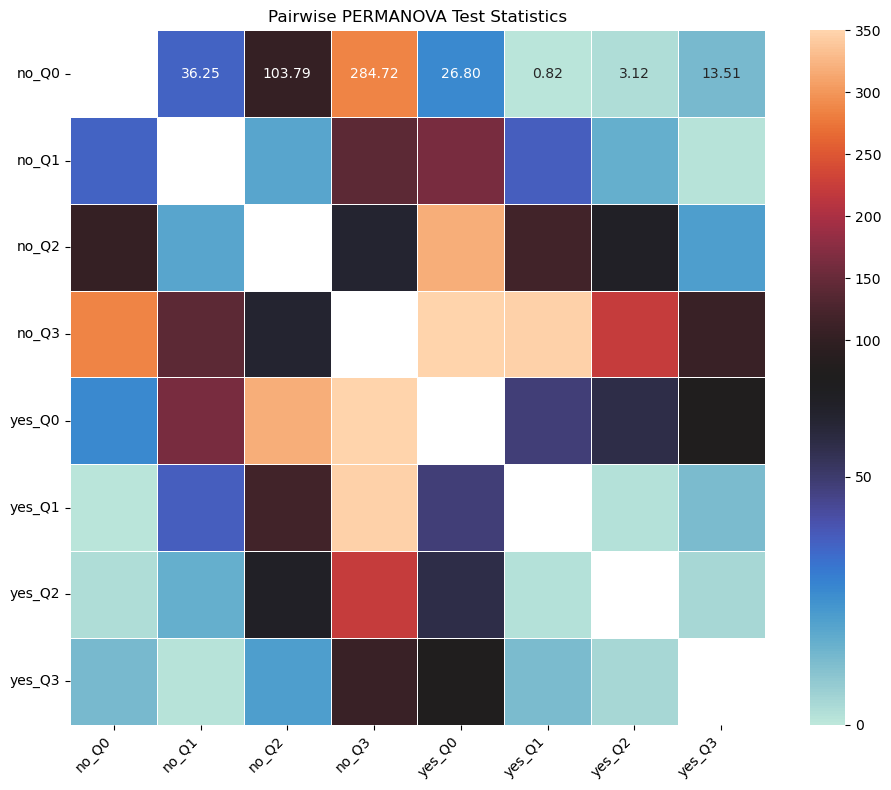

In [67]:
plot_permanova_heatmap(pairwise_results, value_col='Test Statistic')

### P-Value Heatmap

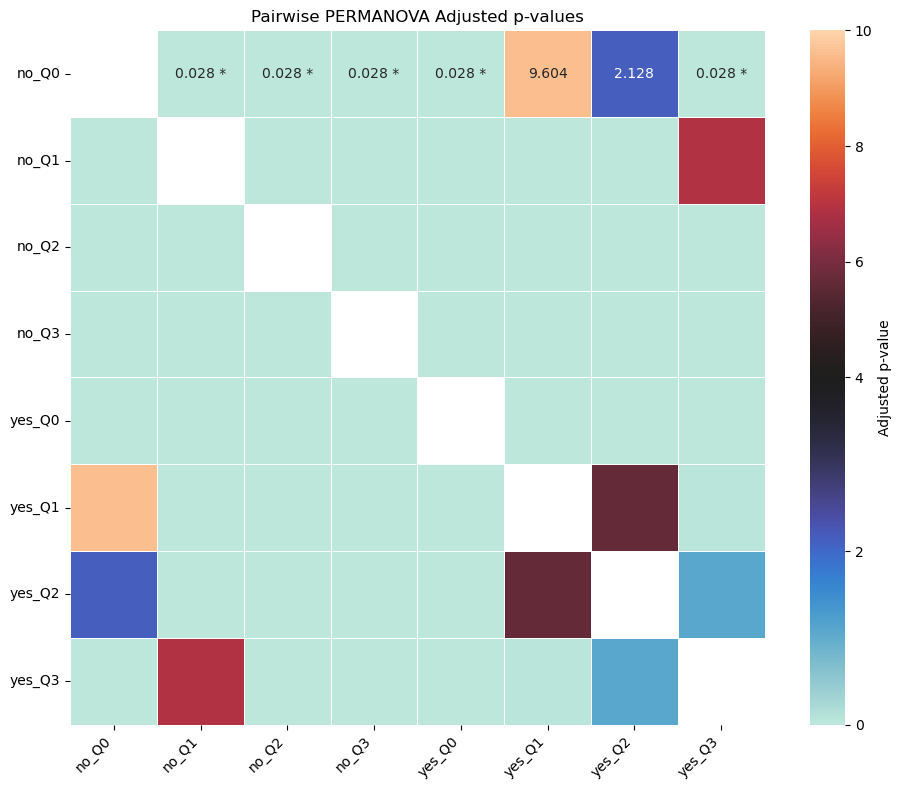

In [68]:
plot_pvalue_heatmap(pairwise_results, value_col='p-value (adjusted)', annot_stars=True)

# Curve Fitting 

## school funding, child poverty

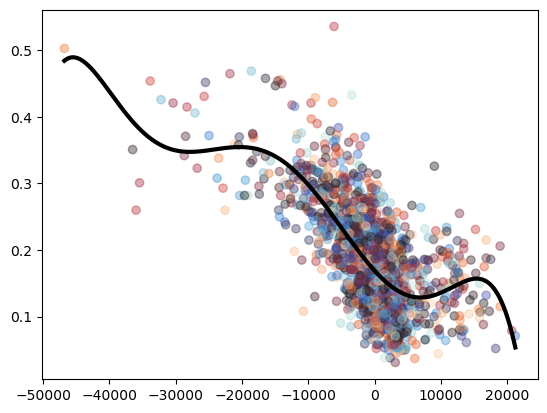

In [137]:

def objective(x, a, b, c, d, e, f, g):
	return a * x +  (b * x**2) + (c*x**3) + (d*x**4) + (e*x**5) + (f* x**6) + g
colors = np.random.randint(1648, size=(1648))
# choose the input and output variables
x, y = agg_select_subset['school_funding_gap'], agg_select_subset['child_poverty_percentage']
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f, g = popt
# plot input vs output
pyplot.scatter(x, y, c=colors, cmap='icefire', alpha=0.4)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f, g)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '-', color='black', linewidth=3)
pyplot.show()

In [138]:
y_pred = objective(x, a, b, c, d, e, f, g)


In [139]:
from sklearn.metrics import r2_score

r2 = r2_score(y, y_pred)
print(f"R²: {r2:.4f}")


R²: 0.4960


# Conclusions

1. When running both multiple regression and Interaction models against7 each y variable, the strongest R squared and p-value pairing was with Child Poverty Percentage